In [29]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [30]:
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import sys
sys.setrecursionlimit(10000)
# torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('sox_io')
# import os
# import random
# from pathlib import Path

import matplotlib.pyplot as plt
# import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

# print(f'Total RAM      : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
# print(f'Available RAM  : {bytes2GB(psutil.virtual_memory().available):5.2f} GB\n')

In [31]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'conv1draw'
normalize = ''#"sample"

In [32]:
transforms_list = [FilterWingbeat(setting='bandpass')]#, TransformWingbeat(setting='psd')]

wbdset = WingbeatsDataset(dsname="twin_cages_experiment/sensorSD", clean=True, verbose=True, transform=FilterWingbeat(setting='bandpass'))
psdset = WingbeatsDataset(dsname="twin_cages_experiment/sensorSD", clean=True, verbose=True, transform=transforms.Compose([FilterWingbeat(setting='bandpass'), TransformWingbeat(setting='psdl2')]))
# dloader = DataLoader(wbdset.clean_subset, batch_size=32, num_workers=16)

Cleaning dataset twin_cages_experiment/sensorSD..	:   0%|          | 0/4 [00:00<?, ?it/s]

Found 110 in dataset: twin_cages_experiment/sensorSD, and 1 label(s): ['sensorSD']


Cleaning dataset twin_cages_experiment/sensorSD..	: 100%|██████████| 4/4 [00:00<00:00,  8.97it/s]

Found 59 in dataset: twin_cages_experiment/sensorSD, and 1 label(s): ['sensorSD']
No custom label applied.
Found 59 in dataset: twin_cages_experiment/sensorSD, and 1 label(s): ['sensorSD']
No custom label applied.


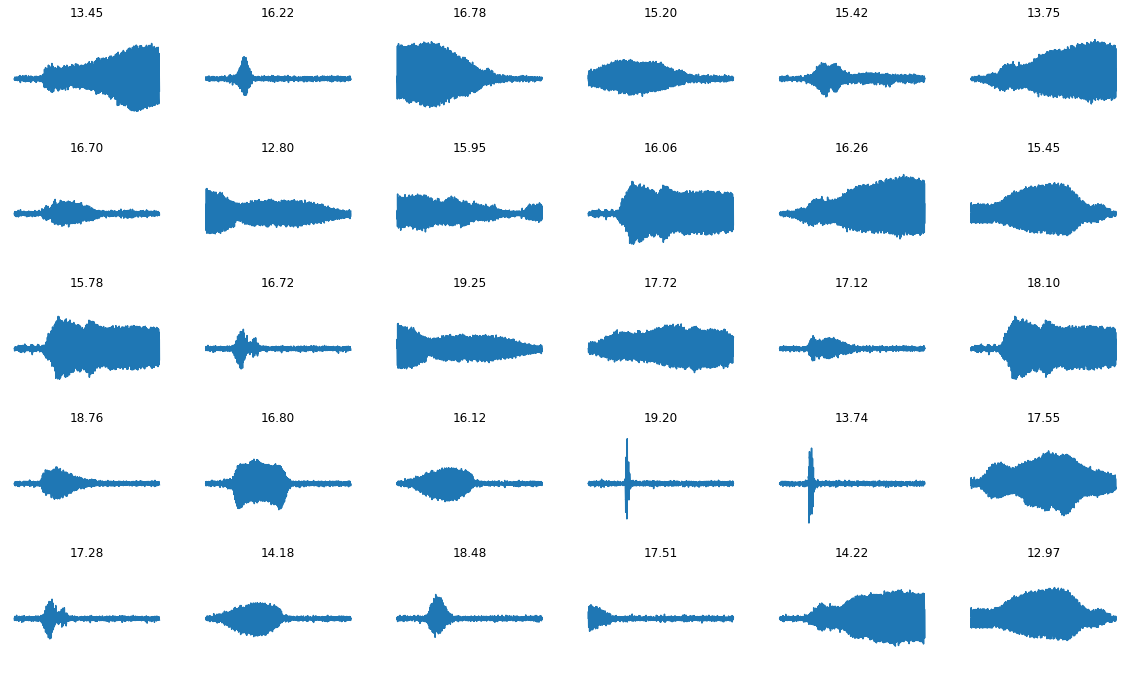

In [33]:
rands = np.random.randint(0,len(wbdset), len(wbdset))

plt.figure(figsize=(20,12))
for i in range(30):
    plt.subplot(5,6,i+1)
    sig = wbdset[rands[i]][0]
    plt.plot(sig.T)
    plt.title(f"{wbdset.sums[i]:.2f}")#, absum:{sig.abs().sum():.4f}")
    plt.axis('off')
    plt.ylim(-.065,.065)

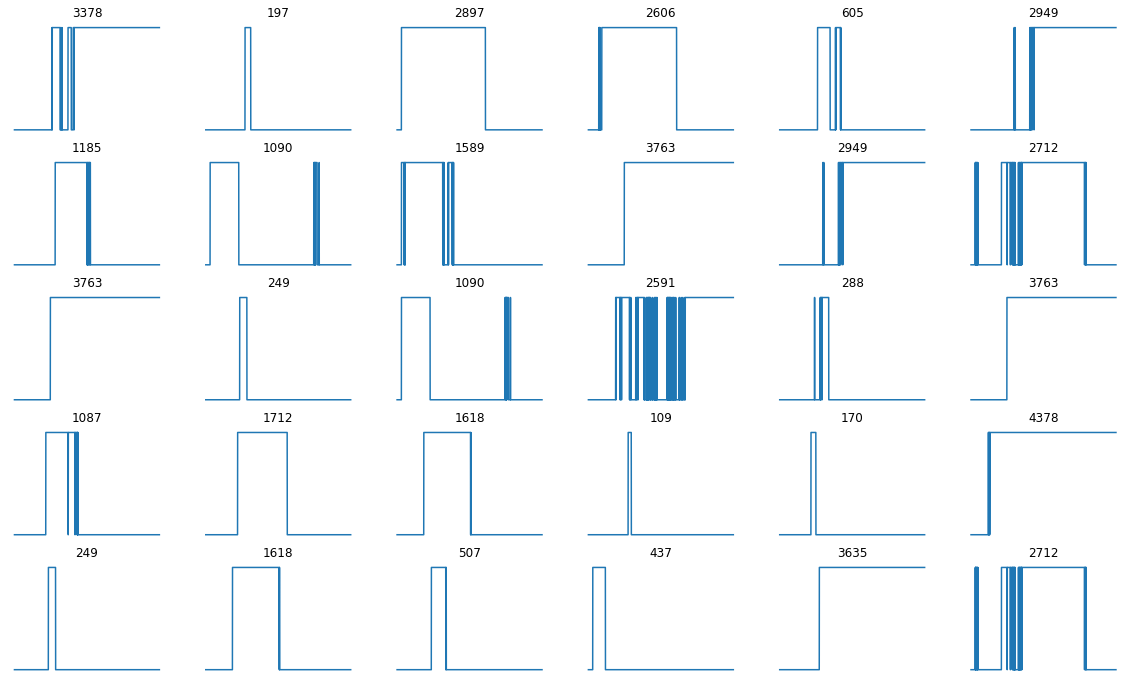

In [34]:
plt.figure(figsize=(20,12))
for i in range(30):
    plt.subplot(5,6,i+1)
    sig = wbdset[rands[i]][0]
    sig = (pd.Series(sig.squeeze()).abs().rolling(150).median()>0.005).astype(int)
    sig.plot()
    plt.title(sig.sum())
    plt.axis('off')

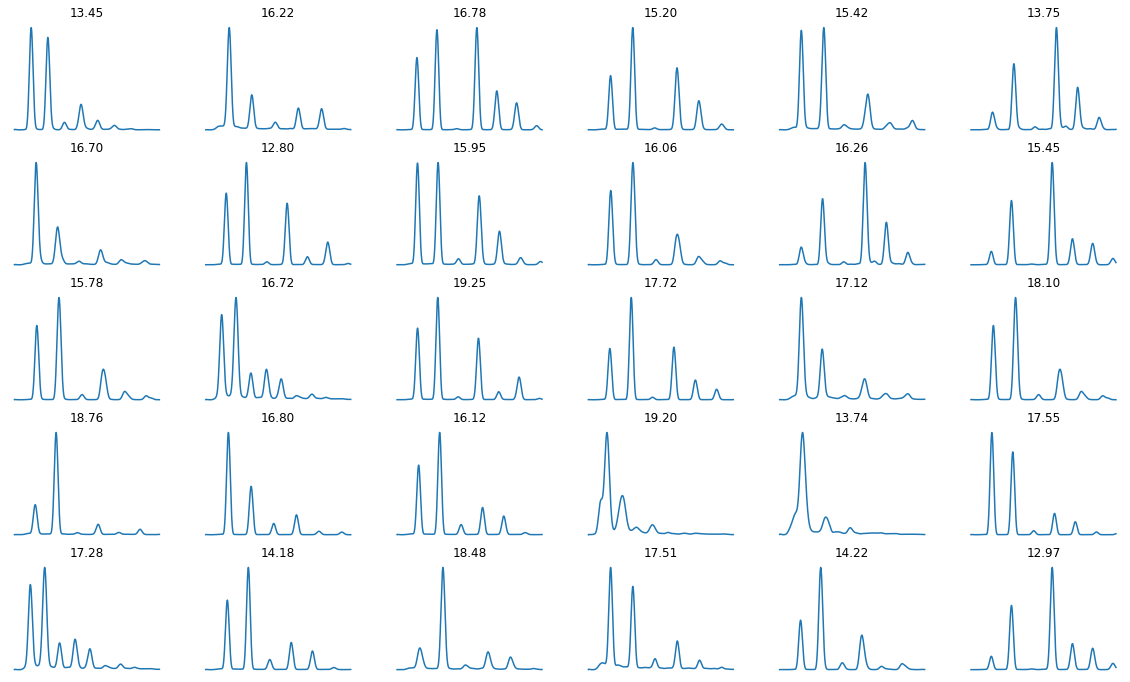

In [35]:
plt.figure(figsize=(20,12))
for i in range(30):
    plt.subplot(5,6,i+1)
    
    sig = psdset[rands[i]][0][0,:1600]
    plt.plot(sig.T)
    plt.title(f"{psdset.sums[i]:.2f}")
    plt.axis('off')